## Evaluation of diffusion model against benchmarks

**Read forecasts and chirps** 

In [9]:
import xarray as xr

ecmwf = xr.open_mfdataset('data/test/*.zarr').ecmwf
chirps = xr.open_mfdataset('data/test/*.zarr').chirps

/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-pa

**Read benchmarks** 

In [10]:
qm = xr.open_zarr('data/benchmarks_results/QM/test_quantile_mapping.zarr')
climax = xr.open_zarr('data/benchmarks_results/ClimaX/test_climax.zarr')
bilint = xr.open_zarr('data/benchmarks_results/bilinear/test_bilinear.zarr')

#### Diffusion Model inference

In [1]:
import jax
import functools
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from read_data import get_cond_ecmwf_dataset, get_mean_std_data
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

2024-03-20 14:30:11.173027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/envs/user/swirl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cond_workdir = "/home/u/amine.barkaoui/chkpts/cond_diffusion_ecmwf_wetseas_100k"

DATA_STD = 0.31

num_samples_per_cond = 5

In [3]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=DATA_STD,
)

In [4]:
cond_denoiser_model = dfn_lib.PreconditionedDenoiser(
    out_channels=1,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=DATA_STD,
    cond_resize_method="cubic",
    cond_embed_dim=128,
)

In [5]:
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{cond_workdir}/checkpoints", step=None
)
# Construct the inference function
cond_denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=cond_denoiser_model
)

cond_sampler = dfn_lib.SdeSampler(
    input_shape=(28, 28, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=cond_denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

2024-03-20 14:30:19.785157: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
generate = jax.jit(
    functools.partial(cond_sampler.generate, num_samples_per_cond)
)

In [11]:
batch_size=256

n_iter = ecmwf.time.size // batch_size + 1

In [12]:
test_ds = iter(get_cond_ecmwf_dataset(split="test", batch_size=batch_size))

for batch in tqdm(range(n_iter)):
    batch_test = next(test_ds)
    
    test_batch_cond = batch_test["cond"]

    cond_samples = jax.vmap(generate, in_axes=(0, 0, None))(
        jax.random.split(jax.random.PRNGKey(8888), batch_size),
        test_batch_cond,
        None,  # Guidance inputs = None since no guidance transforms involved
    )
    
    np.save(f"data/diffusion/batch_{batch}_full", cond_samples)
    
    del cond_samples
    del test_batch_cond

2024-03-20 14:31:52.875056: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
  0%|          | 0/1 [00:00<?, ?it/s]2024-03-20 14:32:31.817022: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-20 14:32:32.495305: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performa

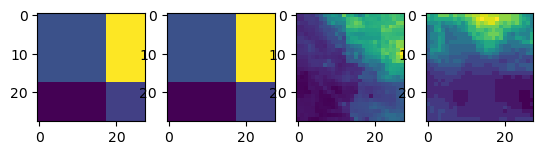

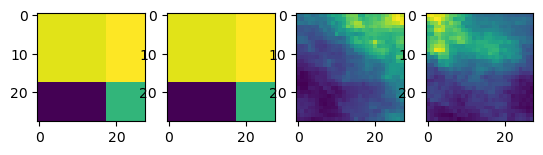

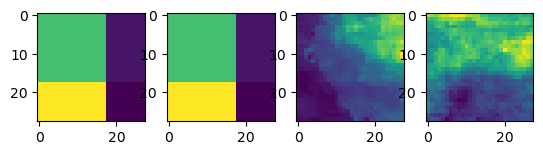

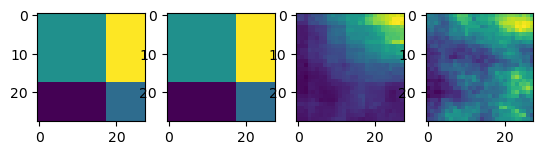

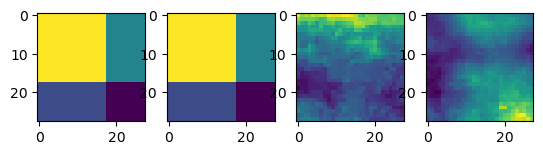

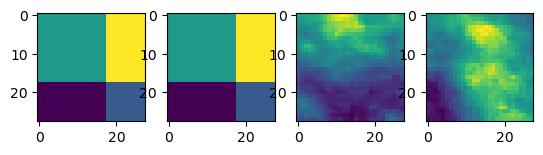

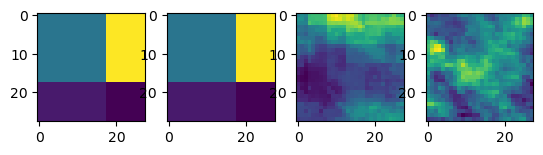

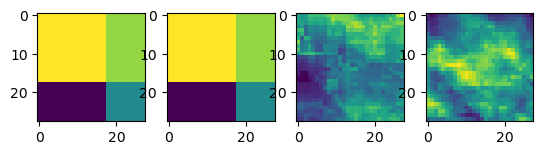

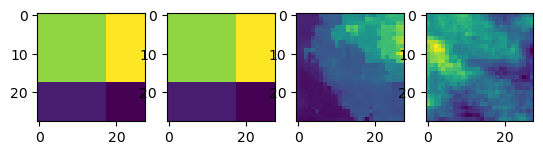

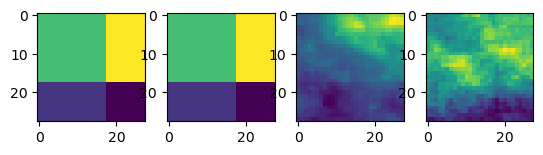

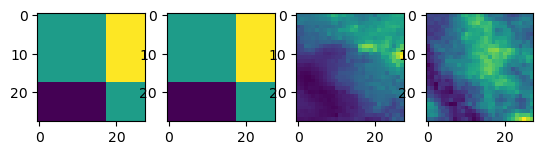

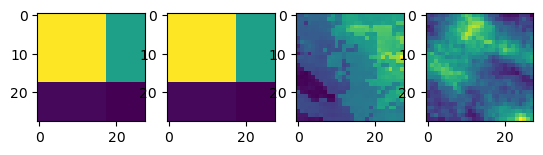

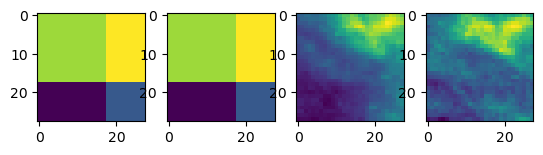

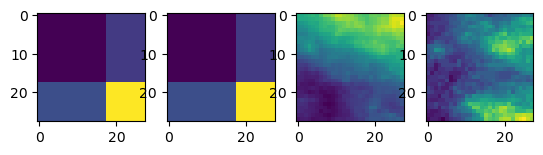

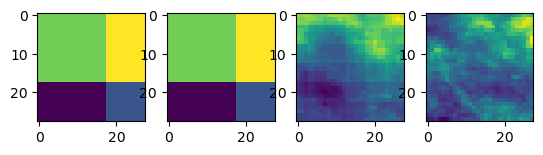

In [13]:
batch_test = next(iter(get_cond_ecmwf_dataset(split="test", batch_size=batch_size)))

test_batch_cond = batch_test["cond"]['channel:low_res']
test_batch_gt = batch_test["x"]

xx = np.load(f"data/diffusion/batch_0_full.npy")

for b in range(15, 30):
    fig, ax = plt.subplots(1, 4)
  
    ax[0].imshow(test_batch_cond[b,:,:,0])
    ax[1].imshow(ecmwf.isel(time=b).values)
    im = ax[2].imshow(np.mean(xx, axis=1)[b,:,:,0])
    #fig.colorbar(im, ax=ax[2])
    ax[3].imshow(test_batch_gt[b,:,:,0])
    
plt.show()

#### Metrics

In [14]:
mean_chirps, var_chirps, mean_ecmwf, var_ecmwf = get_mean_std_data(split="train")

In [15]:
batch_test = next(iter(get_cond_ecmwf_dataset(split="test", batch_size=batch_size)))

test_batch_cond = batch_test["cond"]['channel:low_res']
test_batch_gt = batch_test["x"]

xx = np.load(f"data/diffusion/batch_full.npy")

rmse, mae, r2, pearson = [], [], [], []

for b in range(batch_size):
    pred = np.mean(xx, axis=1)[b, :, :, 0]  * (var_chirps + 1e-4) + mean_chirps
    ground_truth = test_batch_gt[b, :, :, 0]  * (var_chirps + 1e-4) + mean_chirps

    rmse.append(root_mean_squared_error(ground_truth, pred))
    mae.append(mean_absolute_error(ground_truth, pred))
    r2.append(r2_score(ground_truth, pred))
    pearson.append(np.mean(np.corrcoef(ground_truth, pred), axis=(0,1)))

/envs/user/swirl/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/envs/user/swirl/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/envs/user/swirl/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/envs/user/swirl/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/envs/user/swirl/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/envs/user/swirl/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/envs/user/swirl/lib/python3.11/site-packages/numpy/lib/function_base.py:289

7.889372


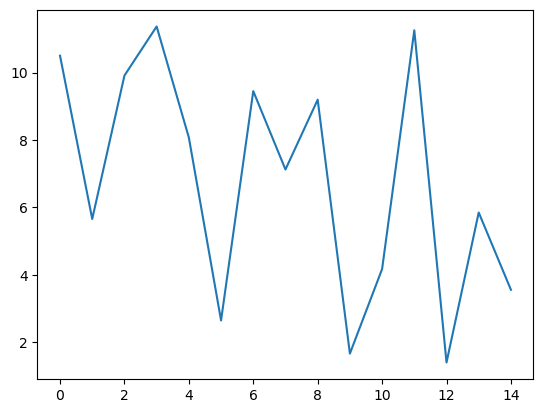

6.6501527


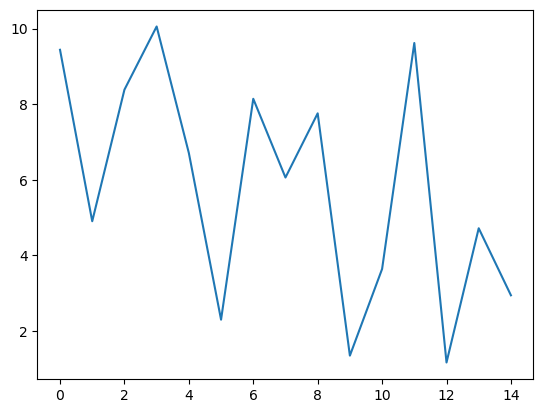

-14.213802756491907


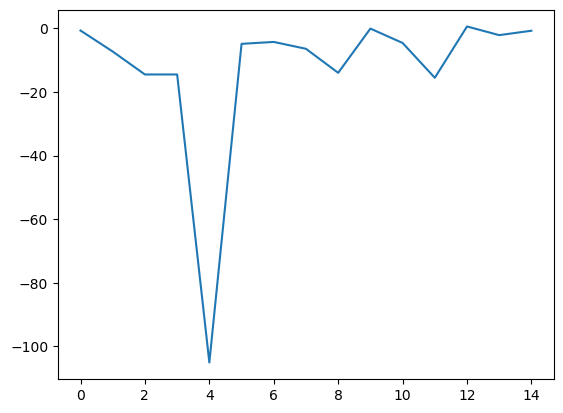

0.510454272694627


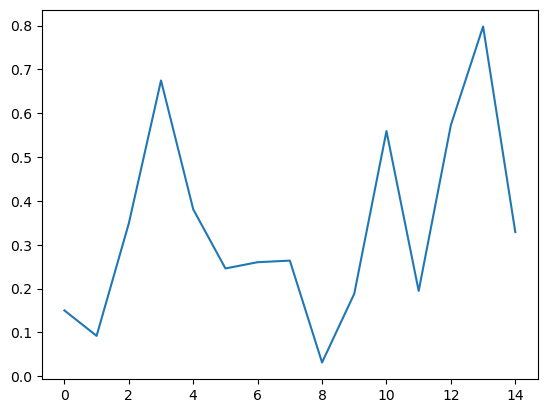

In [18]:
print(np.mean(rmse))
plt.plot(rmse[15:30])
plt.show()

print(np.mean(mae))
plt.plot(mae[15:30])
plt.show()

print(np.mean(np.array(r2)[np.where(np.array(r2) > -1e3)[0]]))
plt.plot(np.array(r2)[np.where(np.array(r2) > -1e3)[0][15:30]])
plt.show()

print(np.mean(np.array(pearson)[~np.isnan(pearson)]))
plt.plot(pearson[15:30])
plt.show()